In [3]:
import math
import json
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


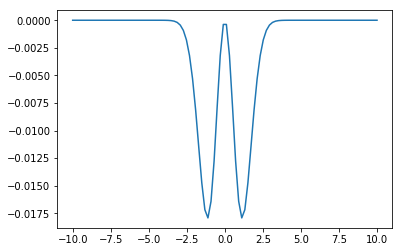

In [167]:
def mexican_hat(x, sigma=1.):
    a = 2./ ( np.sqrt(3*sigma) * np.power(np.pi,0.25 ) )
    b = (1. - (x/sigma)**2 )
    c = np.exp( - x**2/(2.*sigma**2))
    return a*b*c

def W_zero(x):
    a          = 1.0
    lambda_net = 4.0
    beta       = 3.0 / lambda_net**2
    gamma      = 1.05 * beta
    
    x_length_squared = x**2
    
    return a*np.exp(-gamma*x_length_squared) - np.exp(-beta*x_length_squared)

def createCircularMask(h, w, center=None, radius=None):

    if center is None: # use the middle of the image
        center = [int(w/2), int(h/2)]
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask





J = W_zero

x = np.linspace(-10.,10., num=100)
y = J(2*x)

plt.plot(x, y)


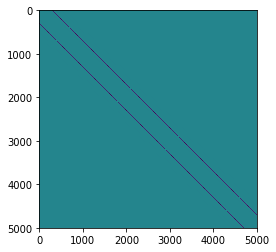

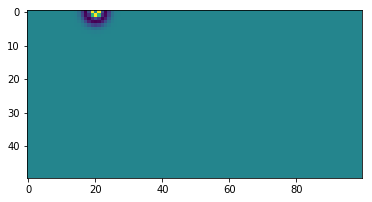

In [168]:
def normalize(x):
    x_   = x - np.amin(x)
    amax = np.amax(x_)

    if amax != 0.:
        x_ = x_/amax
    
    return x_



def create_W(J, D, s=1.0):

    W = np.zeros(D.shape)
    W = J(s*D) 

    np.fill_diagonal(W, 0.0)
    
    for i in range(n):
        W[i,:] -= np.mean(W[i,:])
    
    return W 



ratio = 2.
rx  = 30.
ry  = rx*ratio
nx = 50
ny = nx*int(ratio)
n  = nx*ny 



X = np.indices((nx,ny)).reshape((2,-1)).T/np.array([[float(nx), float(ny)]])
X[:,0] *= rx
X[:,1] *= ry


D = np.zeros((n, n))
for i in range(n):
    for j in range(n):
            D[i,j] = np.linalg.norm( X[i] - X[j])

        

J = mexican_hat
# J = W_zero



W = create_W(J, D, s=1.)



plt.imshow(W)
plt.show()

plt.imshow(W[20].reshape((nx,ny)))
plt.show()



In [166]:
mask = np.ones((nx,ny))

# mask[10:20,50:60]    = 0.
# mask[10:20,115:125]  = 0.


R = np.indices((nx,ny)).reshape((2,-1)).T/np.array([[float(nx), float(ny)]])
R[:,0] *= rx
R[:,1] *= ry

R = R[np.random.choice(n,size=5, replace=False)]
print R.shape


rnd = np.random.sample(5)
print rnd
mask = mask.reshape(-1)
for i in range(n):
    j = np.argmin( np.linalg.norm(R - X[i].reshape((1,2)), axis=1))
    
    mask[i] = rnd[j]

print mask
mask = mask.reshape((nx,ny))
print mask
plt.imshow(mask)
mask = mask.reshape(-1)


(5, 2)
[ 0.99720943  0.13989221  0.9832092   0.84632898  0.89661678]


ValueError: cannot reshape array of size 1 into shape (1,2)

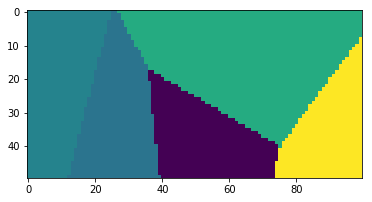

In [176]:
# beta_mask = np.ones((nx,ny))
# beta_mask = beta_mask*np.linspace(1.0,4.,num=ny).reshape((1,ny))



# mask[10:20,50:60]    = 0.
# mask[10:20,115:125]  = 0.


R = np.indices((nx,ny)).reshape((2,-1)).T/np.array([[float(nx), float(ny)]])
R[:,0] *= rx
R[:,1] *= ry

R = R[np.random.choice(n,size=5, replace=False)]

rnd = np.random.sample(5)

beta_mask = np.zeros(n)
for i in range(n):
    j = np.argmin( np.linalg.norm(R - X[i], axis=1))
    beta_mask[i] = 2.5 + (rnd[j] - 0.5)*1.

    
plt.imshow(beta_mask.reshape((nx,ny)))

beta_mask = beta_mask.reshape(-1)


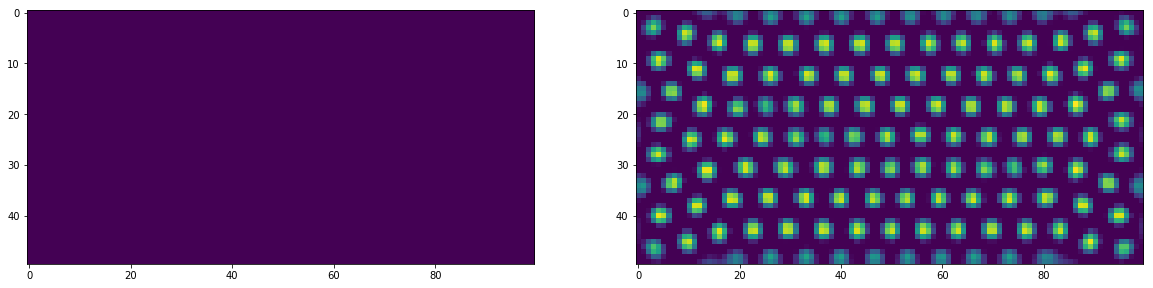

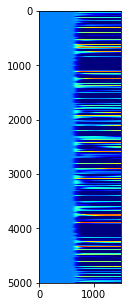

In [184]:
from htmresearch.support.gridcells.utils import cross_correlate
from scipy import ndimage
import numpy.fft as fft
from scipy.special import expit

def relu(x):
    return np.maximum(x, 0.)

def evolve_step(W, b, s, beta=0.):
    dt    = 0.01
    tau   = 1.0
    f     = relu
    noise = np.random.randn(n)*0.001
    noise = 0.
    
    ds    = dt*(f(np.dot(W,s+ noise) + b + beta) - s/tau)
    s_    = s + ds
    s_[mask==0.] = 0.
    if np.sum(s_**2) >0:
            s_ = s_/np.sqrt(np.sum(s_**2))
            
    return s_




T =1500
# X = np.linspace(0.2,0.4,num=T)

S = np.zeros((T,n))




S[0] = np.zeros(n)



Beta = np.ones((T,n))*0.0




for t in range(1,T):
    
    s = S[t-1]
    b = np.zeros(n)
    
    tonic = 0.01
    beta  = Beta[t-1]
    
#     s_ = evolve_step(W, b  + tonic, s, beta_mask*beta) 
    s_ = evolve_step(W, b  + tonic, s) 
    S[t]    = s_

    alpha = 0.01
    Beta[t] = (1. - alpha)*Beta[t-1] - alpha*(s_ - np.mean(s_))


fig, ax = plt.subplots(1, 2, figsize=(20, 10));
ax[0].imshow(S[0].reshape((nx,ny)), label="$s_0$")
ax[1].imshow(S[-1].reshape((nx,ny)), label="$s_1$")
plt.show()


plt.figure(figsize=(20,5))
plt.imshow(S.T, cmap="jet")
plt.show()





(1050, 5000)
done


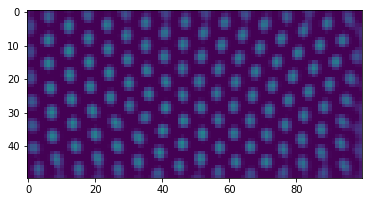

In [179]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation


def update_line(num, data, line):
    line.set_data(data[num].reshape((nx,ny)))
    return line,


fig = plt.figure()


data = S[np.arange(0, T, step=10)]
print data.shape

l = plt.imshow(S[0].reshape((nx,ny)), animated=True)
ani = animation.FuncAnimation(fig, update_line, len(data), fargs=(data, l),
                                   interval=10, blit=True)

ani.save('moving_bumps_rect_pieces2.mp4')
print "done"
# plt.show()

In [ ]:
from JSAnimation.IPython_display import display_animation
from matplotlib import animation

# Set up the axes, making sure the axis ratio is equal
fig = plt.figure(figsize=(6.5, 2.5))
ax = fig.add_axes([0, 0, 1, 1], xlim=(-0.02, 13.02), ylim=(-0.02, 5.02),
                  xticks=range(14), yticks=range(6), aspect='equal', frameon=False)
ax.grid(True)

# Define the shapes of the polygons
P1 = np.array([[0, 0], [5, 0], [5, 2], [0, 0]])
P2 = np.array([[0, 0], [8, 0], [8, 3], [0, 0]])
P3 = np.array([[0, 0], [5, 0], [5, 1], [3, 1], [3, 2], [0, 2], [0, 0]])
P4 = np.array([[0, 1], [3, 1], [3, 0], [5, 0], [5, 2], [0, 2], [0, 1]])

# Draw the empty polygons for the animation
kwds = dict(ec='k', alpha=0.5)
patches = [ax.add_patch(plt.Polygon(0 * P1, fc='g', **kwds)),
           ax.add_patch(plt.Polygon(0 * P2, fc='b', **kwds)),
           ax.add_patch(plt.Polygon(0 * P3, fc='y', **kwds)),
           ax.add_patch(plt.Polygon(0 * P4, fc='r', **kwds))]

# This function moves the polygons as a function of the frame i
Nframes = 30
def animate(nframe):
    f = nframe / (Nframes - 1.0)
    patches[0].set_xy(P1 + (8 - 8 * f, 3 - 3 * f + 0.5 * np.sin(f * np.pi)))
    patches[1].set_xy(P2 + (5 * f, 2 * f - 0.5 * np.sin(f * np.pi)))
    patches[2].set_xy(P3 + (8 - 3 * f, 0))
    patches[3].set_xy(P4 + (8, 1 - f))
    return patches
    
anim = animation.FuncAnimation(fig, animate, frames=Nframes, interval=50)
display_animation(anim, default_mode='once')